## MS5 
Nai Hola, Enrique Hicks de Leon, Zachary Sardi-Santos 

## Action Items
The notebook should read like a report to an employer with appropriate comments and explanations.
1. Include TOC (table of contents) - in progress
2. Describe what libraries your codes depend on. DONE
3. If your codes require specific environment configurations, make sure to explain them. -- DONE
4. Include an illustration/flow chart of your model. This can also be used for your presentation.
5. Make sure a label and an explanation follows every visualization (ex. "Figure 1.2 The above figure displays...") DONE
6. Cite every outside source - No need. 

You can move additional code to an appendix notebook if it helps make the main report notebook more concise.

Notebook Report 

1. Group Canvas number + group member names + TOC (**need group number**)
2. Intro: Motivation, context, and framing of the problem **done**
3. Description of the data, how data was handled **done**
4. EDA specific to report's content, mainly MS3 **done**
5. Modeling approach, logical description of modeling decisions and process **kind of complete (see Final Model Section)**
6. Results: drawing reasonable conclusions & speculations, addressing strengths, limitations, and future works **incomplete; need trading simulation**
7. Overall communication and clarity: good visuals, minimal typos, readability
8. Coding efficiency and style
9. Depth and thoroughness

## Table of Contents
1. Introduction 
2. Data Handling
3. EDA Report
4. Load Preprocessed Data
5. Final Model

## Necessary Libraries

Core Libraries:

numpy: For numerical operations, array handling, and log return calculations

pandas: For data manipulation, time series handling, and DataFrame operations

matplotlib.pyplot: For visualizing distributions, cumulative returns, and portfolio performance

scikit-learn: 

    QuantileRegressor (quantile regression baseline)

    StandardScaler (feature normalization)

    train_test_split (data partitioning)

    Pipeline and check_array utilities

## Specific Environment Configurations

1. !pip install yfinance --> this must be completed in order to download our dataset and run the rest of the code.

## Introduction + Problem Statement + Task Specifics

**Introduction:**
Forecasting stock returns is a notoriously difficult task due to the noisy, nonstationary, and regime-sensitive nature of financial markets. While traditional models often rely on point forecasts (regression techniques), such predictions fail to capture the underlying uncertainty and asymmetry in return distributions — especially in volatile environments. In this project, we explore whether a Transformer-based sequence model can accurately forecast the distribution of IBM’s 5-day log returns, rather than a single value, by predicting the 10th, 50th, and 90th percentiles of the return distribution.

**Problem Statement(s):**  
Our problem statement is twofold:

1. Can a Transformer, trained on rich time series features including technical indicators, macroeconomic variables, calendar effects, and regime flags (market volatility cycles), predict quantiles of log 5 day returns of IBM stock, more accurately (as measured by at least a 10% reduction in pinball loss) than a quantile regression (& GRU) baseline?

2. Can these quantile forecasts translate into a profitable and risk-aware trading strategy?

**Modeling Task:**
- Quantile Regression Predict multiple quantiles (e.g., 10th, 50th, 90th percentiles) to capture the full return distribution.
  
**Architecture:**

- A Transformer model that processes input sequences (e.g., 30-day rolling windows) and outputs the chosen target (quantiles of expected return).

**Loss Functions:**  
  - Quantile loss (pinball loss) for quantile regression.


**Trading Simulation:**
Once the model is trained and outputs quantiles, we have three strategies:
1. Go long (buy) if the 10th percentile of the predicted return is > 0. even in the “worst-case” scenario, returns are expected to be positive
   
2. Avoid or hold cash if the 10th percentile < 0 and 50th percentile is ~ 0.

3. Go Short (sell) if 90th percentile ~ 0

We shall evaluate trading performance using the cumulative return and comparison against the baseline QR model.

## Description of Data
**Summary of Data**
- The data is 16.6 MB in size and spans over 25 years (1998–2025) of daily observations.
- There are 350 total features. The features range from macroeconomic (like CPI, Inflation, USD Index) to market and stock specific features (IBM price data, VIX, Sector ETF prices).

**Data Handling**
- We dropped all rows that had any NaN values and redundant OHLCV features (as explained in EDA below - post forward-fill).
- We computed certain technical indicator features (like SMA) via their respective formulas using other features in our dataset (as explained in EDA below).
- We standardized and took the log of all the technical indicator and market specific features.

## Shifts in Task Specific (Modeling) Approach Via EDA

We chose to pursue the quantile regression method after observing our target variable, log 5 day returns, was approximately normal centered around zero with a thicker left tail. This justifies quantile regression as a predictive task, because the lower‑end quantiles, like 10th percentile quantile, have the most risk information. 

<p align="center">
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/5_day_return_histogram.png" alt="Volume Boxplot" style="width:700px;">
</p>


## Comprehensive EDA Review

## 0. Key Findings
1. **Multicollinearity --> Feature Reduction**
EDA revealed extreme multicollinearity among OHLCV components (Open, High, Low, Close, Volume) for each ticker, in many cases with correlations exceeding 0.95 (e.g., SP500_Open vs SP500_High = 0.999).
- We retained only the Close price per ticker as the core price signal.
- All technical indicators were derived from these Close prices.
- This reduced the number of raw price features while maintaining their trend and volatility information through derived signals.

2. **Heavy-tailed, Skewed Feature Distributions --> Standard Scaling**
The histograms and boxplots showed:
- Volume, volatility, and momentum indicators (e.g., ATR, RSI, OBV) were right-skewed distributions.
- Several indicators had extreme outliers, especially during crisis periods (2008 crisis or 2020 COVID pandemic).
- To prevent these features from dominating training, we will apply log transformations to features like volume and ATR to stabilize variance. We will also use StandardScaler to ensure features had similar scales and were less sensitive to outliers.

<p align="center">
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/volume_boxplot.png" alt="Volume Boxplot" style="width:410px;">                                   
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/volume_histogram.png" alt="Volume Histogram" style="width:500px;">
</p>

3. **Time-Lagged Lead Effect --> 30 day Window**
- Momentum indicators like RSI, MACD, ROC had the strongest correlation to 5 day log returns at 1–2 day lags. Essentially, Momentum indictators from two days prior had the strongest correlation to present day 5 day log return values
- Volatility indicators (e.g., rolling std, ATR) remained predictive over 5–7 days. Essentially, volatility indicators carry signal a week out.
- Essentially, this pointed to the fact using a 30 day window to predict future returns is a smart idea, because of this lagged correlation. We can capture short term momentum effects (signals that work at 1-2 day lags) and retain medium-horizon volatility context (weekly signal) and give the model temporal depth to learn signifiance and correlation of features over time.
<p align="center">
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/lagged_correlation.png" alt="Volume Boxplot" style="width:500px;">                                   
</p>

4. **Market Regimes Exists (via PCA and k-means) --> Need Contextual Features**
- PCA + k-means clustering revealed that the dataset naturally splits into three regimes: Calm, Trending, High Volatility
- Now each data point is labeled with its regime cluster, which is embedded in the Transformer model.
- This will help the model adapt to different market behaviours.
<p align="center">
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/market_regimes.png" alt="Volume Boxplot" style="width:500px;">                                   
</p>

5. **Calendar Effects --> Weekday Dummies**
We observed slightly higher returns on Fridays and Tuesdays, consistent with known market anomalies.
- We added one-hot encoded weekday dummies (is_monday, is_tuesday, etc.) to help the model account for these weekday effects.
<p align="center">
  <img src="https://raw.githubusercontent.com/enriquedlh97/109b-ms4-images/main/weekday_return.png" alt="Volume Boxplot" style="width:500px;">                                   
</p>

## 1. Handling Missing Values

- **Issue:**  
  Macroeconomic indicators like CPI and Unemployment are reported monthly. When these series are resampled to daily frequency, the days before the first report in our range result in NaNs.

- **Solution:**  
  We applied **forward-fill** to propagate the most recent available value forward. In addition, **back-fill** was used after the forward-fill step to fill any remaining gaps. This ensures that the final dataset has continuous daily values without missing data points, which is essential for stable model training.

## 2. Feature Engineering

- **Feature Reduction via Correlation Analysis**
- Check above (reduced OHLCV to just Close)

**Technical Indicator Computation (all computed from IBM Close Price)**
- **Momentum Indicators**:
- RSI (Relative Strength Index, 14-day): Measures recent gain/loss strength
- MACD: Difference between 12-day EMA and 26-day EMA
- ROC (Rate of Change, 10-day): Percentage change in price

- **Volatility Indicators**:
- Rolling standard deviation (20-day): Measures price variability
- ATR (Average True Range, 14-day): Captures range-based volatility
- Bollinger Bands: Upper and lower bounds around a 20-day SMA ± 2σ

- **Trend Indicators**:
- SMA & EMA (20-day and 50-day): Smooth trend signals

**Volume-Based Indicators**:
- OBV (On-Balance Volume): Cumulative measure of volume flow
- MFI (Money Flow Index, 14-day): Volume-weighted momentum

**IBM Return Features (1-day, 5-day, 10-day, 20-day rolling mean)**
- Computed from IBM close price

**Rolling Statistics for Time-Dependent Features**
- For volatility and momentum: Applied rolling windows (e.g., 14, 20, 50 days)

**One hot encoded weekday dummies**
- Capture calendar anomalies, so will input one hot encoded weekdays into Transformer

**Labelled Each Observation in DF with market regime based on PCA & Clustering**
- Market behaviour impacts return, so added market regime label to each observation to capture this affect.


## Data Processing For Baseline Model

In [1]:
!pip install yfinance pandas_datareader

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf 
from pandas_datareader import data as pdr

In [3]:
processed_data = pd.read_csv("processed_data.csv", index_col=0, parse_dates=True)

In [4]:
processed_data.head()

,IBM_Close,IBM_Volume,XLK_Close,XLK_Volume,SP500_Close,SP500_Volume,VIX_Close,TNX_Close,TNX_Volume,Gold_Close,...,XLB_Bollinger_Upper,XLB_Bollinger_Lower,XLB_Bollinger_Mid,XLB_SMA_20,XLB_SMA_50,XLB_EMA_20,XLB_EMA_50,XLB_OBV,XLB_MFI,IBM_Close_raw
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-05,-0.099606,-0.470258,0.346363,-2.972496,-0.379939,-2.624208,0.201485,2.028126,-0.083451,-1.487106,...,-1.232499,-1.199139,-1.218216,-1.218216,-1.230028,-1.228984,-1.219922,-0.787050,1.257550,125.418259
2000-09-06,-0.093356,0.485786,0.313904,-2.226561,-0.398240,-2.277921,0.334005,2.051966,-0.083451,-1.489758,...,-1.232842,-1.199083,-1.218366,-1.218366,-1.229786,-1.227056,-1.219452,-0.786721,1.289070,125.657265
2000-09-07,-0.044919,-0.223576,0.334197,-2.942491,-0.385559,-2.297526,0.145031,2.082383,-0.083451,-1.490089,...,-1.232440,-1.204853,-1.220957,-1.220957,-1.230466,-1.229891,-1.220897,-0.787146,1.021168,127.509560
2000-09-08,-0.141793,-0.060951,0.293285,-2.396839,-0.395452,-2.348439,0.004896,2.061831,-0.083451,-1.491250,...,-1.228996,-1.214018,-1.223624,-1.223624,-1.231115,-1.234032,-1.222938,-0.792567,-0.729634,123.804970
2000-09-11,-0.266793,0.828910,0.260198,-2.301096,-0.401952,-2.482638,-0.004090,2.089782,-0.083451,-1.491581,...,-1.228405,-1.222855,-1.227604,-1.227604,-1.231402,-1.238351,-1.225136,-0.795791,-1.205589,119.024857


## Final Model
We will build our own lightweight Transformer model for this project. This is because any pre-trained transformer models from HuggingFace are trained on language and text corpora, which are not compatible with our continuous time series data.

Model Architecture
1. Inputs: batch of 30 day sequences
2. Embedding projection (Dense): compresses raw numeric features into an FFN-dimension (ff_dim), analogous to word/token embeddings. Allows model to learn which raw signals matter the most before attention. Compression is also efficient. 
3. Transformer Stack: Multi head attention - stacks multiple transformer encoders on top of one another, w/ num_layer stacks
4. GlobalAvgPooling1D: Collapses sequences into one vector
5. Output (Dense): One output value per quantile (so dense of 3)

The reasoning for this model architecture follows that of our GPT and ChatGPT lectures (lectures 17 and 18) and our HW5 parts 2-3. The only notable switch is using a GlobalAvgPooling layer instead of a CLS token concatenation. This is because our task is regression, not classification. 

## Transformer Encoder Block Function + Custom Output Layer MHA Model

In [5]:
import tensorflow as tf

tf.keras.utils.set_random_seed(109)
tf.config.experimental.enable_op_determinism()

#transformer encoder block function 
def transformer_encoder_block(x,num_heads,
                              ff_dim,
                              dropout_rate, ffn_dropout_rate=0.1,
                              attn_dropout_rate=0.1 ):
    #first create attention output embeddings which use tf.layers MHA attribute
    #we do not need to create embeddings because the data is already numerical vectors
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads = num_heads,
        key_dim = x.shape[-1])(x,x) 
    #key_dim is the dimension of key and query matrices and should be x.shape[-1] because there will be a "u"
    #for every token which I assume is each numeric value in the data vector 
    #(x,x) indicates self-attention 
    # (query, value) = (x, x) for self-attentio

    #skip connection, dropout, and layer norm
    #.Add() is the skip connection attribute in tf 
    #do layernorm and dropout next
    x = tf.keras.layers.Add()([x, attention_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    #first dense layer expands to ff_dim 
    ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    #second dense layer projects back to original embed dimension 
    #expand --> nonlinearity --> project which is typical I guess
    
    ffn_output = tf.keras.layers.Dense(x.shape[-1])(ffn_output)
    
    #additional residual and layer norm and dropout
    x = tf.keras.layers.Add()([x, attention_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x 

2025-05-09 12:38:11.455446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 12:38:11.455498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 12:38:11.456221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 12:38:11.461609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#build actual transformer quantile model function
def build_transformer_quantile_model(
    input_shape, #input_shape will be a tuple (30 days, # of features) assuming we pass in all the features
    num_heads, #number of attention heads in the self attention layer
    ff_dim, #how many neurons in dense layer
    num_layers, #how many transformer encoder blocks to stack -- how many should we do? 
    dropout_rate, #dropout rate for a layer
    kernel_regularizer_strength, #L2 regularization on Dense layers kernels
    bias_regularizer_strength, #L2 regularization o nDense layer biases
    quantiles = [0.1, 0.5, 0.9]): #quantiles to predict/output

    inputs = tf.keras.Input(shape=input_shape) #initialize the inputs

    #this Dense layer actually projects the raw features into higher dimensional embedding space (ff_dim)
    #it is like the token embedding
    x = tf.keras.layers.Dense(
        ff_dim,
        kernel_regularizer = tf.keras.regularizers.l2(kernel_regularizer_strength),
        bias_regularizer = tf.keras.regularizers.l2(bias_regularizer_strength)
    )(inputs)

    #stack the transformer encoder blocks on top of one another, num_layer stacks
    #for _ in range(num_layers) and set x = transformer encoder block function
    for _ in range(num_layers):
        x = transformer_encoder_block(x, num_heads = num_heads, ff_dim = ff_dim,
                                      dropout_rate=dropout_rate)
    #we use global average pooling to average over 30 days, flatten into one giant vector
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    #will output a value for each quantile (this is why the number of neurons is len(quantile)
    outputs = tf.keras.layers.Dense(len(quantiles))(x)

    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    return model
    

In [ ]:
#building transformer model for presentation
def build_transformer_quantile_model(
    input_shape, 
    num_heads, 
    ff_dim, 
    num_layers,  
    dropout_rate, 
    kernel_regularizer_strength, 
    bias_regularizer_strength, 
    quantiles = [0.1, 0.5, 0.9]): 

    inputs = tf.keras.Input(shape=input_shape) 

    x = tf.keras.layers.Dense(
        ff_dim,
        kernel_regularizer = tf.keras.regularizers.l2(kernel_regularizer_strength),
        bias_regularizer = tf.keras.regularizers.l2(bias_regularizer_strength)
    )(inputs)

    for _ in range(num_layers):
        x = transformer_encoder_block(x, num_heads = num_heads, ff_dim = ff_dim,
                                      dropout_rate=dropout_rate)
        
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
   
    outputs = tf.keras.layers.Dense(len(quantiles))(x)

    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    return model
    


## Creating 30 Day Input Sequences of The Data 

In [7]:
from tqdm.notebook import tqdm
def create_timeseries_windows_with_metadata(df, window_size=30, target_col='IBM_Return_5d', price_col='IBM_Close_raw'):
    """
    Create time series windows for model input and collect metadata for realistic trading simulation.

    Args:
        df: pd.DataFrame, must include target_col and price_col, and have a datetime index.
        window_size: int, number of past days in each input window.
        target_col: str, name of the target column.
        price_col: str, name of the close price column used for real trading.

    Returns:
        X: np.array of input sequences
        y: np.array of targets
        metadata: pd.DataFrame with entry and exit info
    """
    feature_cols = df.columns.difference([target_col, price_col])

    X = []
    y = []
    metadata = []

    for i in tqdm(range(len(df) - window_size - 5)):
        window_features = df.iloc[i:i+window_size][feature_cols].values
        target_value = df.iloc[i + window_size + 4][target_col]

        # Store input and target
        X.append(window_features)
        y.append(target_value)

        # Now also store trading metadata
        entry_idx = i + window_size
        exit_idx = i + window_size + 5

        entry_date = df.index[entry_idx]
        exit_date = df.index[exit_idx]

        entry_close = df.iloc[entry_idx][price_col]
        exit_close = df.iloc[exit_idx][price_col]

        metadata.append({
            "entry_idx": entry_idx,
            "exit_idx": exit_idx,
            "entry_date": entry_date,
            "exit_date": exit_date,
            "entry_close": entry_close,
            "exit_close": exit_close
        })

    return np.array(X), np.array(y), pd.DataFrame(metadata)

In [8]:
X, y, metadata = create_timeseries_windows_with_metadata(
    processed_data,
)

  0%|          | 0/6145 [00:00<?, ?it/s]

## Custom Loss Function

The tf.keras.compile attribute does not take as input a pinball loss, so we must define our own unique pinball loss function in order to pass it as a valid attribute into compile.

Quantile loss is asymmetric; 
L = max(q(y-y_hat), 1-q(y-y_hat)), so there are two cases:
1. actual outcome is higher than prediction. Loss = q(y-y_hat). If q is small, say 0.1, we only pay a little in terms of loss if we underestimate for this quantile. Which makes sense, because it is our 10%, worst case scenario, so we would hope that the return value for this 10% quantile is lower than the actual return. 
2. actual outcome is lower than prediction. If q1 is small, say 0.1, we pay a lot in terms of loss because the (1-q) term is 0.9.





In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import CosineDecay

def make_quantile_loss_fn(quantiles):
    #creates a tf tensor based on the quantiles
    quantiles = tf.constant(quantiles, dtype=tf.float32)
    
    def quantile_loss(y_true, y_pred):
        #y_true expanded is just the actual 5day log return expanded a dimension so we can compute the loss
        y_true_expanded = tf.expand_dims(y_true, axis=-1)

        #compoute error between actual return and the predicted return based on the quantile 
        err = y_true_expanded - y_pred  

        # Broadcast quantiles: shape (Q,) → (batch, Q)
        q = quantiles[None, :]

        # Pinball: max(q * err, (q-1) * err)
        loss = tf.maximum(q * err, (q - 1) * err)
        #essentially what the pinball loss computes is how far our quantile predictions are from the actual return
        #so like if the 10% quantile prediction is much greater than the actual return, we overestimated the return 
        #(specifically, we underestimated the risk)
        #
        

        # Return average over batch *and* over all quantiles
        return tf.reduce_mean(loss)

    return quantile_loss



quantiles = [0.1, 0.5, 0.9]
pinball_loss_fn = make_quantile_loss_fn(quantiles)


2025-05-09 12:38:26.796866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3a:00.0, compute capability: 8.9


## Formulating the Data into Tensor Architecture For Improved Model Performance

In [10]:
n = len(X)
train_end = int(n*0.7)
val_end   = int(n*0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],     y[val_end:]
metadata_test = metadata[val_end:]


In [11]:
import tensorflow as tf

batch_size = 64

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val,   y_val,   shuffle=False)
test_ds  = make_dataset(X_test,  y_test,  shuffle=False)


In [12]:
tuple(train_ds.take(1).element_spec[0].shape)

(None, 30, 347)

In [13]:
input_shape = tuple(train_ds.take(1).element_spec[0].shape)
model = build_transformer_quantile_model(
    input_shape=(30, 347),  # 30-day window, 350 features
    num_heads=4,
    ff_dim=128,
    num_layers=2,
    dropout_rate=0.01,
    kernel_regularizer_strength=0.00001,
    bias_regularizer_strength=0.00001,
    quantiles=[0.1, 0.5, 0.9]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 347)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 30, 128)              44544     ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 30, 128)              263808    ['dense[0][0]',               
 iHeadAttention)                                                     'dense[0][0]']               
                                                                                                  
 add (Add)                   (None, 30, 128)              0         ['dense[0][0]',           

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# steps_per_epoch = len(processed_data)
# lr_schedule = CosineDecay(
#     initial_learning_rate=0.005,
#     decay_steps=20 * steps_per_epoch,  # total training steps
#     alpha=1e-5  # final learning rate as a fraction of initial
# )
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)

model.compile(
    optimizer=optimizer,
    loss=pinball_loss_fn,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

history = model.fit(train_ds, validation_data = val_ds, epochs = 100, verbose = 1, callbacks=callbacks_list)


Epoch 1/100


2025-05-09 12:38:30.937081: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-09 12:38:31.826638: I external/local_xla/xla/service/service.cc:168] XLA service 0x1498692ca590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-09 12:38:31.826673: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-09 12:38:31.831025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746808711.908806   42042 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 [==============================] - 5s 12ms/step - loss: 0.2039 - mean_absolute_error: 0.8086 - val_loss: 0.0834 - val_mean_absolute_error: 0.5450 - lr: 0.0050
Epoch 2/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0495 - mean_absolute_error: 0.2788 - val_loss: 0.0318 - val_mean_absolute_error: 0.2181 - lr: 0.0050
Epoch 3/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0320 - mean_absolute_error: 0.2001 - val_loss: 0.0559 - val_mean_absolute_error: 0.3541 - lr: 0.0050
Epoch 4/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0343 - mean_absolute_error: 0.1448 - val_loss: 0.0468 - val_mean_absolute_error: 0.2937 - lr: 0.0050
Epoch 5/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0272 - mean_absolute_error: 0.1301 - val_loss: 0.0311 - val_mean_absolute_error: 0.2410 - lr: 0.0050
Epoch 6/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0193 - mean_absolute_error: 0.1075 - val_loss: 0.0377 - 

In [15]:
test_results = model.evaluate(test_ds, verbose = 1)
print(f"Test pinball loss: {test_results[0]:.6f}")
print(f"Test MAE (median): {test_results[1]:.6f}")

15/15 [==============================] - 0s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0427
Test pinball loss: 0.009127
Test MAE (median): 0.042703


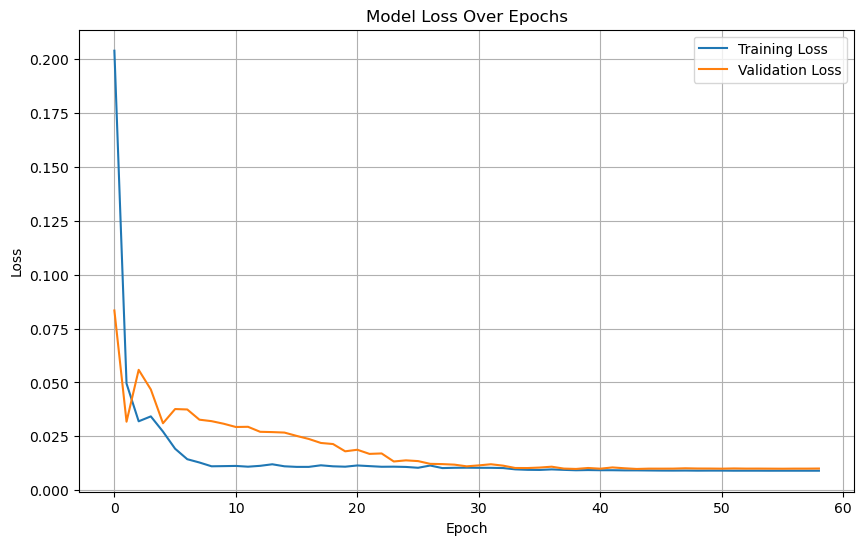

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
plt.close('all')

## Simulated Trading Strategy Step 1: Compile DataFrame of Predictions

The first step is to compile a dataframe of all the predicted quantiles given 30 day sequences of the test dataset (test_ds). 

In [17]:
y_true_list, y_pred_list = [], []
for X_batch, y_batch in test_ds:  #tuple loop, gives x_batch and y_batch pair
    batch_preds = model.predict(X_batch, verbose = 0)
    y_pred_list.append(batch_preds) #this will be a triple list addition because
    #model.predict will return 3 values b/c Dense output is 3 neurons
    y_true_list.append(y_batch.numpy())

y_test_all = np.concatenate(y_true_list, axis = 0)
#q_preds_all[:,0] is 10% forecast, [:,1] the 50% (median), [:,2] the 90% forecast.
q_preds_all = np.vstack(y_pred_list)


In [18]:
#create dataframe of predicted quantiles and actual return
transformer_preds_df = pd.DataFrame({
    'q10':           q_preds_all[:, 0],
    'q50':           q_preds_all[:, 1],
    'q90':           q_preds_all[:, 2],
    'Actual_5d_Return': y_test_all
})

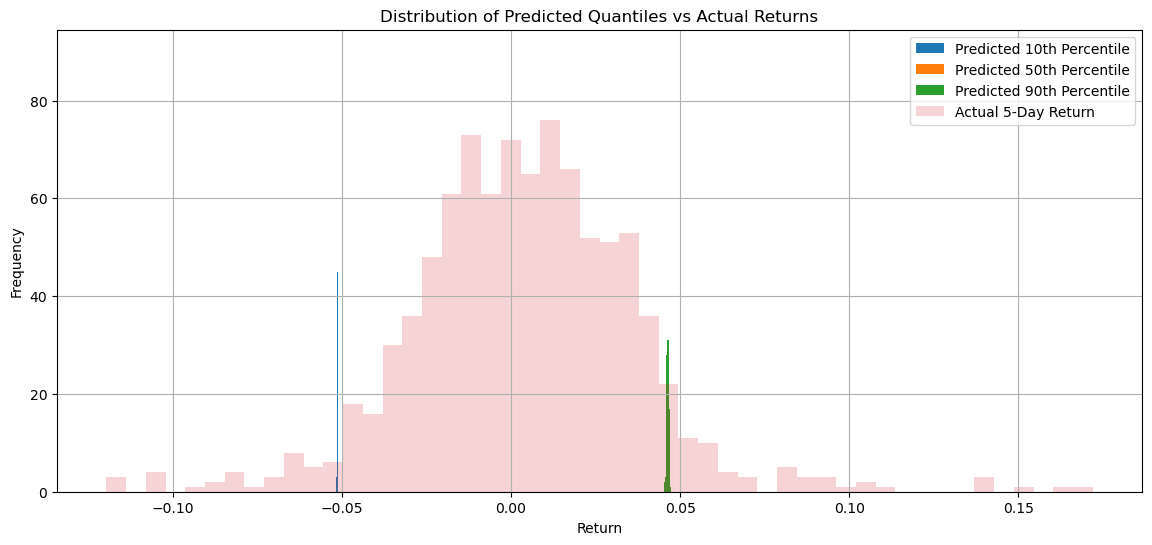

In [38]:
fig = plt.figure(figsize=(14, 6))

plt.hist(transformer_preds_df['q10'], bins=50, alpha=1, label='Predicted 10th Percentile')
plt.hist(transformer_preds_df['q50'], bins=50, alpha=1, label='Predicted 50th Percentile')
plt.hist(transformer_preds_df['q90'], bins=50, alpha=1, label='Predicted 90th Percentile')
plt.hist(transformer_preds_df['Actual_5d_Return'], bins=50, alpha=0.2, label='Actual 5-Day Return')

plt.title('Distribution of Predicted Quantiles vs Actual Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
plt.close("all")

## Simulated Trading Strategy V2: Full Backtest Engine

In [22]:
def plot_ibm_price_with_trade_markers(metadata_frame, trade_marker_list):
    plt.figure(figsize=(16, 6))
    plt.plot(pd.to_datetime(metadata_frame["entry_date"]),
             metadata_frame["entry_close"],
             color="black", label="IBM Close Price")

    for marker in trade_marker_list:
        plt.scatter(marker["date"], marker["price"],
                    marker="^" if marker["side"] == "buy" else "v",
                    color="green" if marker["side"] == "buy" else "red",
                    s=85)

    plt.title("IBM Close Price with Trade Signals")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_portfolio_and_benchmark(trading_series, buy_hold_series):
    plt.figure(figsize=(16, 6))
    plt.plot(trading_series.index, trading_series.values,
             label="Trading Portfolio", color="blue")
    plt.plot(buy_hold_series.index, buy_hold_series.values,
             label="Buy & Hold Benchmark", color="orange", linestyle="--")
    plt.title("Trading Portfolio vs Buy-and-Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_basic_metrics(portfolio_series, initial_cash_amount):
    daily_returns = portfolio_series.pct_change().dropna()
    total_return = portfolio_series.iloc[-1] / initial_cash_amount - 1.0
    days_covered = (portfolio_series.index[-1] -
                    portfolio_series.index[0]).days
    annualised_return = (1.0 + total_return) ** (365.0 / days_covered) - 1.0
    maximum_drawdown = (portfolio_series / portfolio_series.cummax() -
                        1.0).min()
    annualised_volatility = daily_returns.std() * np.sqrt(252)
    final_portfolio_value = portfolio_series.iloc[-1]
    return (total_return, annualised_return,
            maximum_drawdown, annualised_volatility, final_portfolio_value)

def run_quantile_backtest(
    prediction_frame,
    metadata_frame,
    *,
    initial_cash_amount=100_000,
    cash_fraction_at_risk=0.5,
    commission_rate_per_side=0.001,
    bias_buffer_normal_return=0.002, # >= 0.2 % median to choose a direction
    skew_buffer_normal_return=0.002, # >= 0.2 % extra tail in same direction
    stop_loss_enabled=True,
    holding_period_rows=5,
    plot_results=True
):

    prediction_frame = prediction_frame.reset_index(drop=True)
    metadata_frame = metadata_frame.reset_index(drop=True)
    bias_buffer_log_return = np.log1p(bias_buffer_normal_return)
    skew_buffer_log_return = np.log1p(skew_buffer_normal_return)

    # buy and hold
    initial_close_price = metadata_frame["entry_close"].iloc[0]
    benchmark_share_quantity = initial_cash_amount / initial_close_price
    buy_hold_series = metadata_frame["entry_close"] * benchmark_share_quantity
    buy_hold_series.index = pd.to_datetime(metadata_frame["entry_date"])

    cash_balance = float(initial_cash_amount)
    equity_curve_values, equity_curve_dates = [], []
    total_commission_paid = 0.0
    open_position = None
    trade_marker_list = []

    total_rows = len(prediction_frame)

    for row_index in range(total_rows):
        quantile_10, quantile_50, quantile_90 = \
            prediction_frame.loc[row_index, ["q10", "q50", "q90"]]
        current_date = metadata_frame.loc[row_index, "entry_date"]
        current_close_price = metadata_frame.loc[row_index, "entry_close"]

        # close position if holding period is complete
        if open_position and row_index == open_position["exit_row_index"]:
            direction_of_trade = open_position["direction"]
            share_quantity = open_position["share_quantity"]
            cash_used_for_trade = open_position["cash_used_for_trade"]

            market_value_now = share_quantity * current_close_price
            profit_or_loss = (market_value_now - cash_used_for_trade) * direction_of_trade
            exit_commission = market_value_now * commission_rate_per_side
            total_commission_paid += exit_commission

            if direction_of_trade == 1:
                cash_balance += cash_used_for_trade
            cash_balance += profit_or_loss - exit_commission

            trade_marker_list.append({
                "date": current_date,
                "price": current_close_price,
                "side": "sell" if direction_of_trade == 1 else "buy"
            })
            open_position = None

        # stop-loss
        if open_position and stop_loss_enabled:
            direction_of_trade = open_position["direction"]
            entry_price = open_position["entry_price"]
            cumulative_return = direction_of_trade * (current_close_price / entry_price - 1.0)

            if (direction_of_trade == 1 and cumulative_return < quantile_10) or \
               (direction_of_trade == -1 and cumulative_return > quantile_90):
                # close early
                market_value_now = open_position["share_quantity"] * current_close_price
                profit_or_loss = (market_value_now - open_position["cash_used_for_trade"]) * direction_of_trade
                exit_commission = market_value_now * commission_rate_per_side
                total_commission_paid += exit_commission

                if direction_of_trade == 1:
                    cash_balance += open_position["cash_used_for_trade"]
                cash_balance += profit_or_loss - exit_commission

                trade_marker_list.append({
                    "date": current_date,
                    "price": current_close_price,
                    "side": "sell" if direction_of_trade == 1 else "buy"
                })
                open_position = None

        # open new position
        if open_position is None and row_index + holding_period_rows < total_rows:
            direction_signal = 0
            if (quantile_50 > bias_buffer_log_return and
                    (quantile_90 - quantile_50) >= skew_buffer_log_return):
                direction_signal = 1 # long
            elif (quantile_50 < -bias_buffer_log_return and
                    (quantile_50 - quantile_10) >= skew_buffer_log_return):
                direction_signal = -1# short

            if direction_signal != 0:
                cash_to_invest = cash_balance * cash_fraction_at_risk
                share_quantity = cash_to_invest / current_close_price
                entry_commission = cash_to_invest * commission_rate_per_side
                total_commission_paid += entry_commission

                if direction_signal == 1: # pay for shares on long
                    cash_balance -= cash_to_invest
                cash_balance -= entry_commission

                open_position = {
                    "direction": direction_signal,
                    "share_quantity": share_quantity,
                    "cash_used_for_trade": cash_to_invest,
                    "entry_price": current_close_price,
                    "exit_row_index": row_index + holding_period_rows
                }

                trade_marker_list.append({
                    "date": current_date,
                    "price": current_close_price,
                    "side": "buy" if direction_signal == 1 else "sell"
                })

        portfolio_value_today = cash_balance
        if open_position:
            direction_of_trade = open_position["direction"]
            share_quantity = open_position["share_quantity"]
            position_value = share_quantity * current_close_price * direction_of_trade
            if direction_of_trade == -1: # add margin deposit for short
                portfolio_value_today += open_position["cash_used_for_trade"]
            portfolio_value_today += position_value

        equity_curve_dates.append(current_date)
        equity_curve_values.append(portfolio_value_today)

    trading_portfolio_series = pd.Series(equity_curve_values,
                                         index=pd.to_datetime(equity_curve_dates))

    if plot_results:
        plot_ibm_price_with_trade_markers(metadata_frame, trade_marker_list)
        plot_portfolio_and_benchmark(trading_portfolio_series, buy_hold_series)

    trading_metrics = compute_basic_metrics(trading_portfolio_series, initial_cash_amount)
    benchmark_metrics = compute_basic_metrics(buy_hold_series, initial_cash_amount)

    def print_metrics_block(label, metrics_tuple):
        total_ret, annual_ret, max_dd, annual_vol, final_val = metrics_tuple
        print(f"\n\t {label} ")
        print(f"Final value:          ${final_val:,.2f}")
        print(f"Total return:         {total_ret:.2%}")
        print(f"Annualised return:    {annual_ret:.2%}")
        print(f"Maximum draw-down:    {max_dd:.2%}")
        print(f"Annual volatility:    {annual_vol:.2%}")

    print(f"\nTotal commissions paid: ${total_commission_paid:,.2f}")
    print_metrics_block("Trading Portfolio", trading_metrics)
    print_metrics_block("Buy-and-Hold Benchmark", benchmark_metrics)

    return {
        "trading_portfolio": trading_portfolio_series,
        "buy_hold_portfolio": buy_hold_series,
        "total_commissions_paid": total_commission_paid
    }


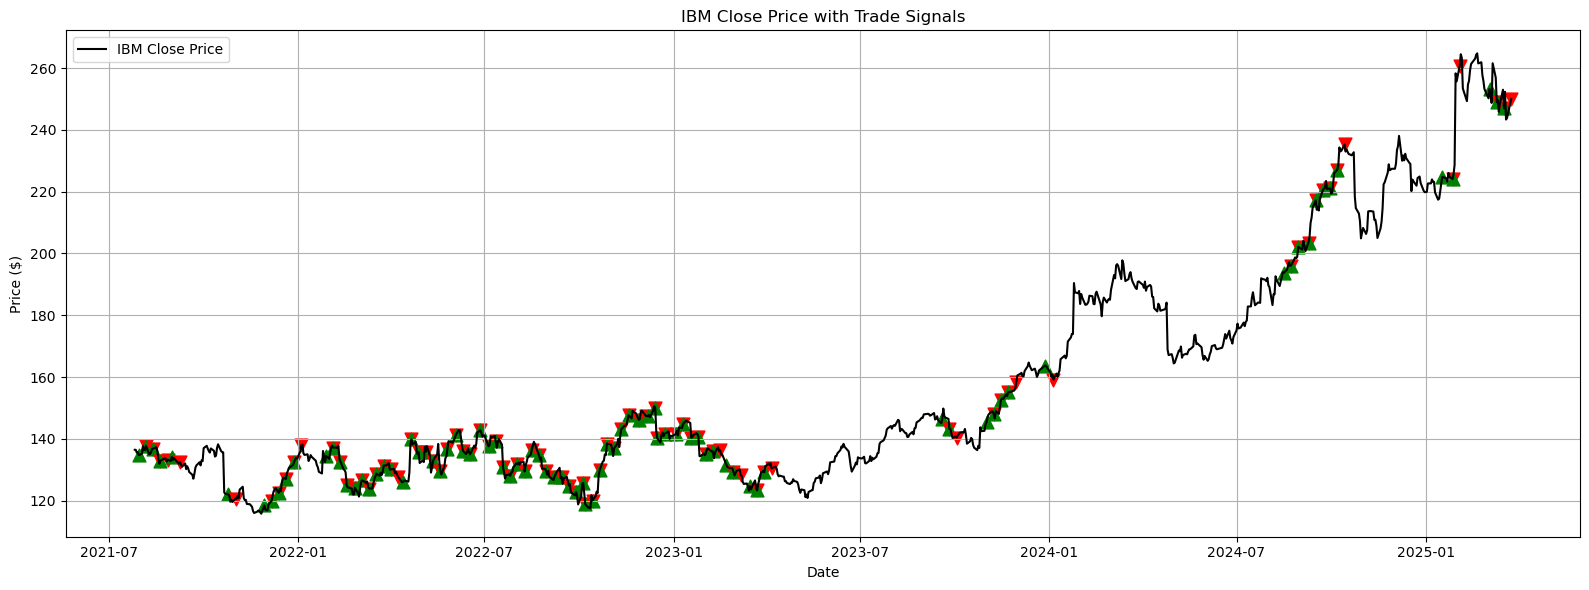

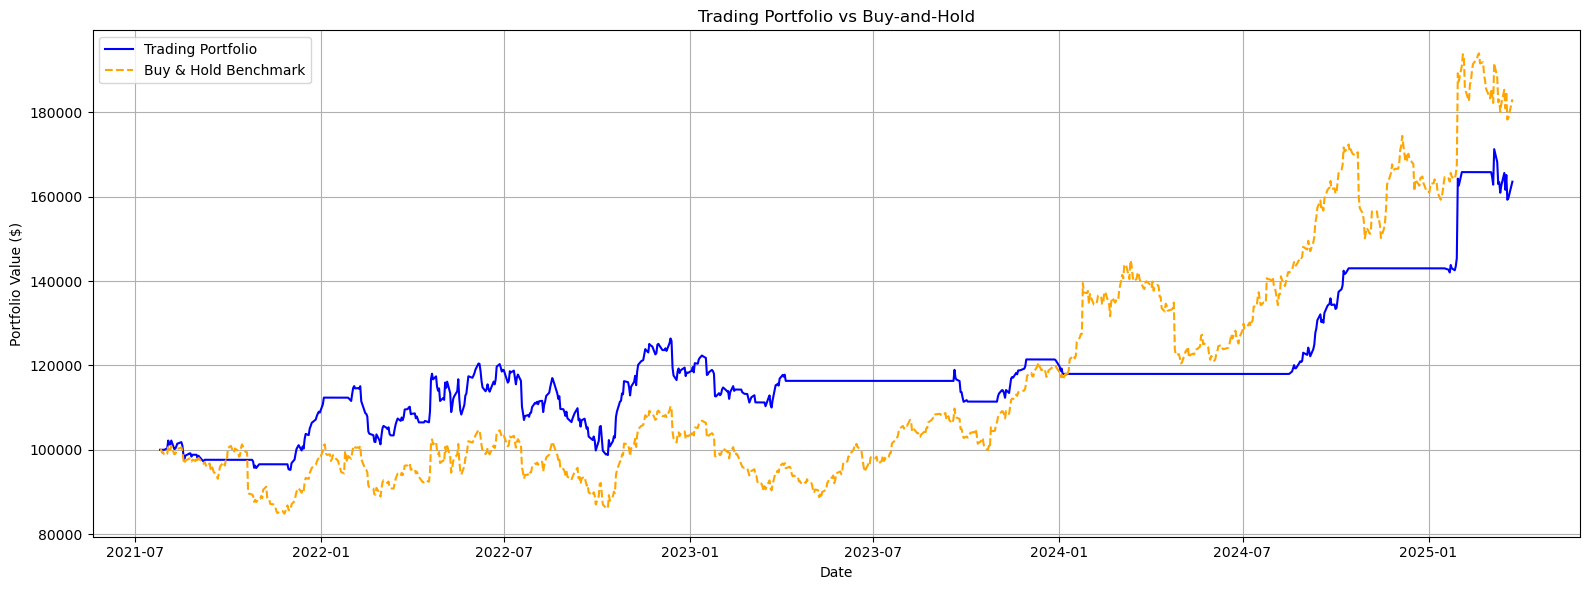


Total commissions paid: $2,056.69

	 Trading Portfolio 
Final value:          $163,548.38
Total return:         63.55%
Annualised return:    14.36%
Maximum draw-down:    -18.01%
Annual volatility:    16.41%

	 Buy-and-Hold Benchmark 
Final value:          $183,088.46
Total return:         83.09%
Annualised return:    17.94%
Maximum draw-down:    -19.71%
Annual volatility:    22.72%


In [23]:
results = run_quantile_backtest(
    prediction_frame=transformer_preds_df,
    metadata_frame=metadata_test,
    initial_cash_amount=100_000,
    cash_fraction_at_risk=1,
    commission_rate_per_side=0.0001,
    bias_buffer_normal_return=0.00057,
    skew_buffer_normal_return=0.03,
    stop_loss_enabled=True,
    holding_period_rows=5,
    plot_results=True
)


## Baseline Model

The Baseline Model has two options
1. A Two-Fold model, similar to our transformer -- models the returns distribtution across x day sequence length and simulates a trading strategy based on that distribution.
2. Two singular models, one that models the returns distribution across x day sequence length, and another that simulates a trading strategy based on a different technique, such as "Moving Crossover SMA".

We will pursue the first option as we believe having a baseline model that essentially runs the same functional process as our Transformer will be best for evaluating and measuring performance -- as two separate baseline models will not simulate trades based on the return distribution, which is a task we aim to accomplish with our Transformer model.

**Quantile Regression Baseline Model (30 Day Input Sequence, Model Distribution of 5 Day Returns)**

Since Quantile Regression is a static model that cannot model lengthy sequences, we summarize each 30-day feature window into a flat feature vector via rolling mean operations. This allows us to retain the most important statistical properties of the past 30 days in a form that Quantile Regression can interpret.

X_mean is an array of all the mean values of all the 30 day sequences created. Shape (6145, 349).

In [24]:
X_mean = X.mean(axis=1)

In [25]:
X_mean.shape

(6145, 347)

## Quantile Regression Baseline

Have to drop NaN rows as there was a problem with technical indicators having NaN values with the 30-day sequences.

GPT explanation - "Some original technical indicators (like RSI, MACD, ATR) naturally produce NaN values in their initial periods (e.g., first 14 days, 20 days).

When you build 30-day windows, early windows that touch NaNs infect your features."

In [26]:
# combine into one DataFrame
temp_df = pd.DataFrame(X_mean)
temp_df['target'] = y

# drop rows with any NaN
temp_df = temp_df.dropna()

# Separate back into X and y
X_mean_clean = temp_df.drop(columns='target').values
y_clean = temp_df['target'].values

In [27]:
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split


#split data into train and test
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(X_mean_clean, y_clean, metadata, test_size=0.15, shuffle=False)

# (shuffle=False because it's time series)

#fit model on training data
model_q10 = QuantileRegressor(quantile=0.1, alpha=0).fit(X_train, y_train)
model_q50 = QuantileRegressor(quantile=0.5, alpha=0).fit(X_train, y_train)
model_q90 = QuantileRegressor(quantile=0.9, alpha=0).fit(X_train, y_train)

#predict on test data
q10_preds = model_q10.predict(X_test)
q50_preds = model_q50.predict(X_test)
q90_preds = model_q90.predict(X_test)

#build prediction dataframe for plotting
preds_df = pd.DataFrame({
    'q10': q10_preds,
    'q50': q50_preds,
    'q90': q90_preds,
    'Actual_5d_Return': y_test
})



## Quantile Baseline Predicting Quantiles

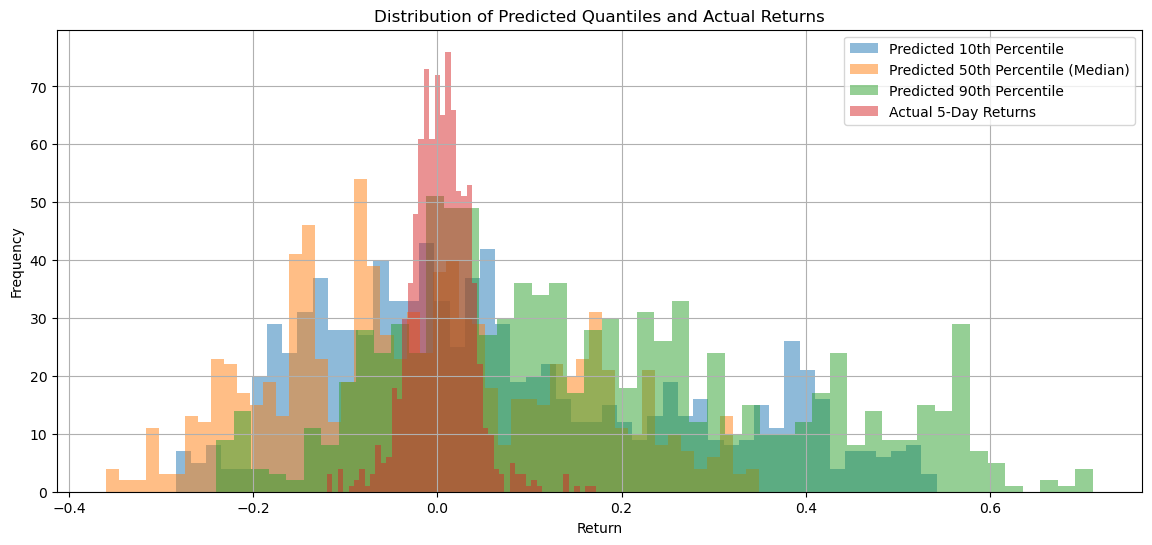

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

#plot predicted quantiles
plt.hist(preds_df['q10'], bins=50, alpha=0.5, label='Predicted 10th Percentile')
plt.hist(preds_df['q50'], bins=50, alpha=0.5, label='Predicted 50th Percentile (Median)')
plt.hist(preds_df['q90'], bins=50, alpha=0.5, label='Predicted 90th Percentile')

#plot actual returns
plt.hist(preds_df['Actual_5d_Return'], bins=50, alpha=0.5, label='Actual 5-Day Returns')

plt.title('Distribution of Predicted Quantiles and Actual Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Pinball loss (also called quantile loss) penalizes under-predictions and over-predictions asymmetrically, depending on the quantile.

Pinball Loss = max[(q * (y_true - y_pred)), (q-1 * (y_true - y_pred))]

In [29]:
def pinball_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    loss = np.maximum(quantile * error, (quantile - 1)*error)
    return np.mean(loss)

loss_q10 = pinball_loss(preds_df['Actual_5d_Return'], preds_df['q10'], 0.1)
loss_q50 = pinball_loss(preds_df['Actual_5d_Return'], preds_df['q50'], 0.5)
loss_q90 = pinball_loss(preds_df['Actual_5d_Return'], preds_df['q90'], 0.9)

# Print results
print(f"Pinball Loss for 10th Quantile: {loss_q10:.6f}")
print(f"Pinball Loss for 50th Quantile: {loss_q50:.6f}")
print(f"Pinball Loss for 90th Quantile: {loss_q90:.6f}")

Pinball Loss for 10th Quantile: 0.106312
Pinball Loss for 50th Quantile: 0.065760
Pinball Loss for 90th Quantile: 0.034589


## Trading Simulation With Quantile Baseline

## Trading Simulation Strategy v2
   Using run_quantile_backtest function defined above, we run the exact same trading simulation strategy as before. 

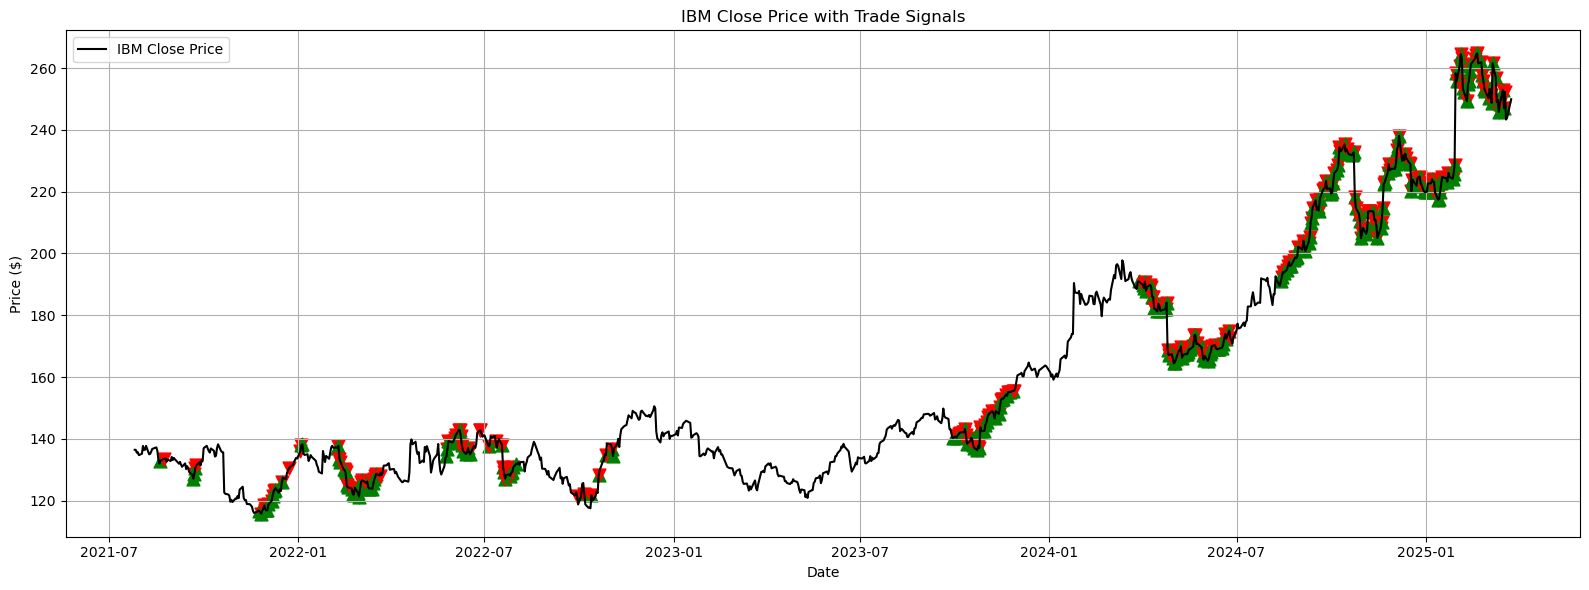

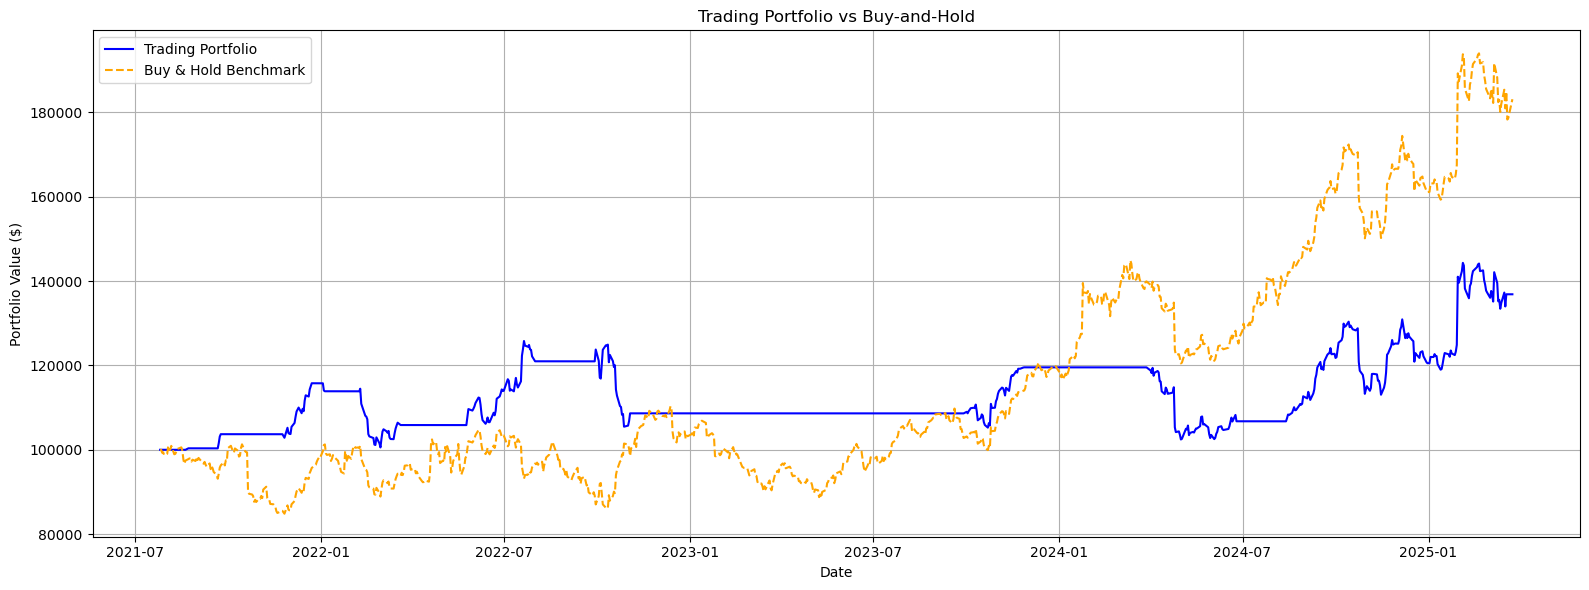


Total commissions paid: $7,681.12

	 Trading Portfolio 
Final value:          $136,854.97
Total return:         36.85%
Annualised return:    8.94%
Maximum draw-down:    -18.55%
Annual volatility:    15.66%

	 Buy-and-Hold Benchmark 
Final value:          $183,088.46
Total return:         83.09%
Annualised return:    17.94%
Maximum draw-down:    -19.71%
Annual volatility:    22.72%


In [33]:
results = run_quantile_backtest(
    prediction_frame=preds_df,
    metadata_frame=metadata_test,
    initial_cash_amount=100_000,
    cash_fraction_at_risk=1,
    commission_rate_per_side=0.0001,
    bias_buffer_normal_return=0.00057,
    skew_buffer_normal_return=0.03,
    stop_loss_enabled=True,
    holding_period_rows=5,
    plot_results=True
)

## Results of Predicting Quantiles
Overall, what we have seen is excellent evidence that our Transformer model has learned a generalizable quantile-forecasting mapping of 5-day log returns based on financial time series data.

1. **Overall Performance**: Our quantile regression baseline had a pinball loss on the order of 1-13 raw scale. Dropping to a pinball loss of 0.008 is a massive improvemenet. Several order of magnitudes (OOMs) improvement. Our goal was to have a 10% reduction in pinball loss compared to the baseline -- we have smashed this goal.
2. **Overfitting/Underfitting**: Well it is clear we are not underfitting. In terms of overfitting, our training and validation pinball loss differs by less than 10%, train vs val MAE less than 8%. So the model is generalizing nicely.
3. **Residual Error**: A <1% pinball loss means the model's quantile bands are, on average, within about 1 percentage point of the true return. A 3.8% median MAE is quite reasonable given typical 5-day log-return volatility (~2–4%).


## Results of Simulated Trading Strategy

1. **Transformer Model Much Better Returns With Lower Cost**
The Transformer strategy turns $100$K into $163.5$K (63.6 % gain) vs. the QR baseline’s $136.9$K (36.9 %). That’s a +26.7 percentage point boost in total return — and at the same time it pays only $2$K in commissions vs. $7.7 K for the baseline.

2. **Higher risk-adjusted performance**
Despite a slightly higher volatility (16.4 % vs. 15.7 %), the Transformer’s annualised return (14.4 %) is higher. So much so that its Sharpe ratio (≈0.88) exceeds both the baseline’s (≈0.57) and buy-and-hold’s (≈0.79). The Sharpe ratio is a mathematical indication that excess returns over time may be the result of volatility and risk rather than investing skill. A Sharpe ratio between 1-3 is excellent - so our model is nearly there! 

3. **Comparable draw-downs**
Both active strategies actually produce smaller maximum draw-downs (~−18 %) than buy-and-hold (−19.7 %), suggesting the quantile-based methods offer some downside protection.

4. **Closing the gap to buy-and-hold**
Buy-and-hold still yields the highest absolute return (83 %), but the Transformer strategy closes most of that gap while trading dynamically (turning over capital, paying commissions) and doing so with superior risk-return trade-offs.